In [1]:
#!/usr/bin/env python3

##############################################################################
# Block Group Home Values
##############################################################################
#
# Load datasets
#

import geopandas as gpd
from shapely import wkt
import fiona
import pandas as pd
import os
import wget
import zipfile
import numpy as np 
from datetime import datetime
import pickle

#
# Zillow research data 
#

ZHVI_all = pd.read_csv('data/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv') # Zillow Home Value Index (ZHVI), All Housing Tyes
ZHVI_Single = pd.read_csv('data/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv') # Zillow Home Value Index (ZHVI), Single Family Residences
ZHVI_Condos = pd.read_csv('data/Zip_zhvi_uc_condo_tier_0.33_0.67_sm_sa_month.csv') # Zillow Home Value Index (ZHVI), Condos
ZORI_all = pd.read_csv('data/Zip_zori_uc_sfrcondomfr_sm_sa_month.csv') # Zillow Observed Rent Index (ZORI)

"""
ZHVI_all.shape (26323, 310)
ZHVI_Single.shape (26217, 310)
ZHVI_Condos.shape (6507, 310)
ZORI_all.shape (6965, 130)

The Zillow research data files can be downloaded from https://www.zillow.com/research/data/.
Each of the download files has the filename format
    {geography}_{publication}_{metric}_{smoothing}_{seasonally adjusted}_{periodicity}
    where 
            geography = 'Zip'
            publication = ['zhvi','zori']
            smoothing = 'sm'
            seasonally adjusted = 'sa'
            periodicity = 'month'
            metric = depends upon publication

Then, each file has a shared format for the corresponding metric.

    RegionID is unique key
    RegionName is also unique, it's the actual ZIP code
    RegionType is all 'zip'
    State and StateName are equal to each other, US state abbreviations (51 values)
    City is the ZIP code's city name.  NYC is on 
    Metro is the MSA name like "Chicago-Naperville-Elgin, IL-IN-WI",   
    CountyName also associated County
    followed by a series of columns named by the reported monthend date '2024-11-30','2024-12-31','2025-01-31', eg

ZIP codes cross county borders so I don't know how County or Metro can be used.
As the month columns go back in history, they increase in NA values.
"""

zillow = pd.merge(pd.merge(pd.merge(
            ZHVI_all[['RegionName','2024-12-31']].rename({'RegionName':'zip_code', '2024-12-31':'ZHVI All Housing Types'},axis=1),
            ZHVI_Single[['RegionName','2024-12-31']].rename({'RegionName':'zip_code', '2024-12-31':'ZHVI Single Family Homes'},axis=1), 
                on='zip_code', how='outer'),
            ZHVI_Condos[['RegionName','2024-12-31']].rename({'RegionName':'zip_code', '2024-12-31':'ZHVI Condos/Coops'},axis=1),
                on='zip_code', how='outer'),
            ZORI_all[['RegionName','2024-12-31']].rename({'RegionName':'zip_code', '2024-12-31':'ZORI All Housing Types'},axis=1),
                on='zip_code', how='outer')
zillow.reset_index(inplace=True,drop=True)
zillow["zip_code"] = zillow.zip_code.astype(str).str.zfill(5)

print("Zillow data ready.",zillow.shape[0],"ZIP codes") # 26375 

#
# ZIP Code boundaries from Dotlas on Databricks Marketplace
#

print("Loading ZIP code shapes")
zipsource = pd.read_csv("data\\us_zipcodes-2025-03-01.tsv", sep="\t", 
                   dtype={'state': str,'zip_code': str,'geometry': str,})

zipsource['geometry'] = zipsource['geometry'].apply(wkt.loads)

zipshapes = gpd.GeoDataFrame(zipsource, geometry='geometry')
zipshapes = zipshapes.set_crs('epsg:3395')   # to match the blockgroups crs
zipshapes.reset_index(inplace=True,drop=True)

"""
The ZIP code geographies are blockgrouphomevaluesed openly by Doltas using Databricks data marketplace.
These files have the form ['state', 'zip_code', 'geometry'] where: 
    state is 2 character state abbreviation for 51 states; 50 states and DC, not PR or other territories
    zip_code is the 5 digit form
    geometry is the standard shapefile text with polygons of latitudes and longitude pairs
"""

print("ZIP code shapes are ready.",zipshapes.shape[0],"rows available.") # 33092 rows

#
# Merge Zillow data and ZIP code shapes
#
zipcodes = zipshapes.merge(zillow, on='zip_code') # 64 of zillows zip codes don't have TIGER shapes
zipcodes = zipcodes[zipcodes[['ZHVI All Housing Types','ZHVI Single Family Homes', 'ZHVI Condos/Coops', 'ZORI All Housing Types']]\
                    .isna().sum(axis=1) != 4] # 9 ZIP codes have NA values for all Zillow estimates.

print("ZIP merge yields",zipcodes.shape[0],"rows")

#
# Get the Combined Statistical Areas, associated with County FIPS for mapping
#
# https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html

csacolumns = ['CBSA Code','Metropolitan Division Code','CSA Code','CBSA Title','Metropolitan/Micropolitan Statistical Area',
              'Metropolitan Division Title','CSA Title','County/County Equivalent','State Name',
              'FIPS State Code','FIPS County Code','Central/Outlying County',]

csa = pd.read_excel("data\\list1_2023.xlsx", skiprows = 3, header=None, names = csacolumns)
csa = csa[~csa.isna().all(axis=1)]

widths = [5,3,2,3]
cols = ['Metropolitan Division Code', 'CSA Code', 'FIPS State Code', 'FIPS County Code']
for c in range(len(widths)):
    csa[cols[c]] = csa[cols[c]].astype('Int64').astype(str).str.zfill(widths[c])

csa['StateCounty'] = csa['FIPS State Code'] + csa['FIPS County Code']

#
# Block Group shapes
#

"""
The Block Group geographies are maintained by the US Census Bureau in its TIGER/Line publications.
They are revised with each Decennial Census, so the 2020 version is appropriate until 2030.
TIGER provides one file for each state, from the Census' ftp website.

As geodatabase files, each tiger file has just one layer, with the same name as the filename.
Each has these columns:
    STATEFP - the US state's 2 digit FIPS code which progress alphabetically, '01' for Alabama, eg
    COUNTYFP - the County's 3 digit FIPS code
    TRACTCE - the 6 digit Census Tract code, within the County
    BLKGRPCE - the 1 digit blockgroup code within the Tract
    GEOID - a concatenation of STATEFP, COUNTYFP, TRACTCE and BLKGRPCE
    GEOIDFQ - the GEOID with the US country code prefix
    # the columns above are used as keys, the GEOID gathers them all, so it's used in this analysis.  
    INTPTLAT, INTPTLON - the latitude and longitude of the area's center (centroid)
    NAMELSAD - the current name and translated legal/statistical area description; this is mostly 'Block Group X' where X is the BLKGRPCE
    MTFCC - is the level of Census geography, which in this data is all block group level G5030
    FUNCSTAT - teh functional status of the area as active, discontinued or other 
    ALAND, AWATER - the area of land or water in the geography
    geometry - the area defines as a polygon of latitudes and longitudes

"""
"""
#
# Download the TIGER/Line files
#
states = pd.read_csv("https://raw.githubusercontent.com/OpenEnvironments/core/refs/heads/main/states.csv")

for state in list(states.StateFIPS.astype(str).str.zfill(2)):
    url = "https://www2.census.gov/geo/tiger/TIGER2024/BG/tl_2024_"+state+"_bg.zip"	
    try:
        filename = wget.download(url,out = 'data')
        print(f"Downloaded {filename}")
    except:
        print(url,"failed")

#
# Unzip them
#
for shapefile in os.listdir('data'):
    if shapefile[:3] == 'tl_':
        with zipfile.ZipFile('data/'+shapefile, 'r') as zip_ref:
            zip_ref.extractall('data/'+shapefile[:-4])
"""

bglist = []
print('Appending block group shapefiles')
for shapefile in ['data/'+s for s in os.listdir('data') if 'tl_' in s if '.' not in s]:
    print(shapefile,end=",")
    bglist.append(gpd.read_file(shapefile))

blockgroups = pd.concat(bglist, axis=0)
blockgroups = blockgroups.set_crs('epsg:3395', allow_override=True)  
blockgroups.reset_index(inplace=True,drop=True)
blockgroups.drop(['NAMELSAD', 'MTFCC', 'FUNCSTAT',], axis=1, inplace=True) # These columns are meaningless here or all the same value
print("Done.",blockgroups.shape[0],"block groups available.")

Zillow data ready. 26375 ZIP codes
Loading ZIP code shapes
ZIP code shapes are ready. 33092 rows available.
ZIP merge yields 26370 rows
Appending block group shapefiles
data/tl_2024_01_bg,data/tl_2024_02_bg,data/tl_2024_04_bg,data/tl_2024_05_bg,data/tl_2024_06_bg,data/tl_2024_08_bg,data/tl_2024_09_bg,data/tl_2024_10_bg,data/tl_2024_11_bg,data/tl_2024_12_bg,data/tl_2024_13_bg,data/tl_2024_15_bg,data/tl_2024_16_bg,data/tl_2024_17_bg,data/tl_2024_18_bg,data/tl_2024_19_bg,data/tl_2024_20_bg,data/tl_2024_21_bg,data/tl_2024_22_bg,data/tl_2024_23_bg,data/tl_2024_24_bg,data/tl_2024_25_bg,data/tl_2024_26_bg,data/tl_2024_27_bg,data/tl_2024_28_bg,data/tl_2024_29_bg,data/tl_2024_30_bg,data/tl_2024_31_bg,data/tl_2024_32_bg,data/tl_2024_33_bg,data/tl_2024_34_bg,data/tl_2024_35_bg,data/tl_2024_36_bg,data/tl_2024_37_bg,data/tl_2024_38_bg,data/tl_2024_39_bg,data/tl_2024_40_bg,data/tl_2024_41_bg,data/tl_2024_42_bg,data/tl_2024_44_bg,data/tl_2024_45_bg,data/tl_2024_46_bg,data/tl_2024_47_bg,data/tl_2024_4

In [2]:
#
# For each block group,
#     1. find the ZIP code(s) that overlay each block group.
#     2. assign estimates of each Zillow detail as the weighted average across the overlaying ZIP codes
#

# find the ZIP codes that overlay each block group
start = datetime.now()
intersections = blockgroups.overlay(zipcodes, how='intersection', keep_geom_type=False) 
print("Intersection complete. Duration:",datetime.now()-start)

start = datetime.now()
grouped = intersections.groupby('GEOID')
print("Grouping complete. Duration:",datetime.now()-start)

# for each block group, inherit the Zillow variables from overlaid ZIP codes 
bgvec = []  # list of blockgroups to become a geodataframe at the end
bgcounter = 0
start = datetime.now()
for name, blockgroup in grouped:
    bg = {}
    bgcounter += 1
    if bgcounter == 10000:
        bgcounter = 0
        print('10K processed in',datetime.now() - start,datetime.now())
        start = datetime.now()

    bg['GEOID'] = name
    bg['ZIP Codes Overlaying'] = blockgroup.zip_code.to_list()
    # Calculate the weighted average of the overlaying ZIP code(s)
    bg['ZHVI All Housing Types'] = (blockgroup['ZHVI All Housing Types'] * blockgroup.area / blockgroup.area.sum()).sum()
    bg['ZHVI Single Family Homes'] = (blockgroup['ZHVI Single Family Homes'] * blockgroup.area / blockgroup.area.sum()).sum()
    bg['ZHVI Condos/Coops'] = (blockgroup['ZHVI Condos/Coops'] * blockgroup.area / blockgroup.area.sum()).sum()
    bg['ZORI All Housing Types'] = (blockgroup['ZORI All Housing Types'] * blockgroup.area / blockgroup.area.sum()).sum()        
    bgvec.append(bg)

# The process so far only handles blockgroups that have overlaying ZIPs
# There're no unassociated blockgroups in the results

blockgrouphomevalues = pd.merge(blockgroups,gpd.GeoDataFrame(bgvec),on='GEOID',how='outer')
blockgrouphomevalues.to_pickle('blockgrouphomevalues.pkl')
# The geometry of each block group can be found, by joining the dataset to block group cartographics
blockgrouphomevalues.drop('geometry', axis=1).to_csv('blockgrouphomevalues.csv')
print("blockgrouphomevaluesed pickle")

Intersection complete. Duration: 0:01:34.483311
Grouping complete. Duration: 0:00:00
10K processed in 0:00:09.497982 2025-03-07 11:19:27.331752
10K processed in 0:00:09.048944 2025-03-07 11:19:36.380696
10K processed in 0:00:08.995430 2025-03-07 11:19:45.376126
10K processed in 0:00:08.983068 2025-03-07 11:19:54.359194
10K processed in 0:00:09.166363 2025-03-07 11:20:03.526569
10K processed in 0:00:09.126489 2025-03-07 11:20:12.653058
10K processed in 0:00:09.291340 2025-03-07 11:20:21.944398
10K processed in 0:00:09.219097 2025-03-07 11:20:31.163495
10K processed in 0:00:09.237476 2025-03-07 11:20:40.400971
10K processed in 0:00:09.272032 2025-03-07 11:20:49.673003
10K processed in 0:00:08.917247 2025-03-07 11:20:58.590250
10K processed in 0:00:09.011219 2025-03-07 11:21:07.601469
10K processed in 0:00:09.078844 2025-03-07 11:21:16.680313
10K processed in 0:00:09.156173 2025-03-07 11:21:25.836486
10K processed in 0:00:09.080627 2025-03-07 11:21:34.917113
10K processed in 0:00:09.15468

In [3]:
#
# Restarting session
#

import geopandas as gpd
from shapely import wkt
import fiona
import pandas as pd
import os
import numpy as np 
from datetime import datetime
from matplotlib import pyplot as plt
import pickle

blockgrouphomevalues = pd.read_pickle('blockgrouphomevalues.pkl')

C:\Users\micha\anaconda3\envs\geotools\lib\site-packages\geopandas\geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


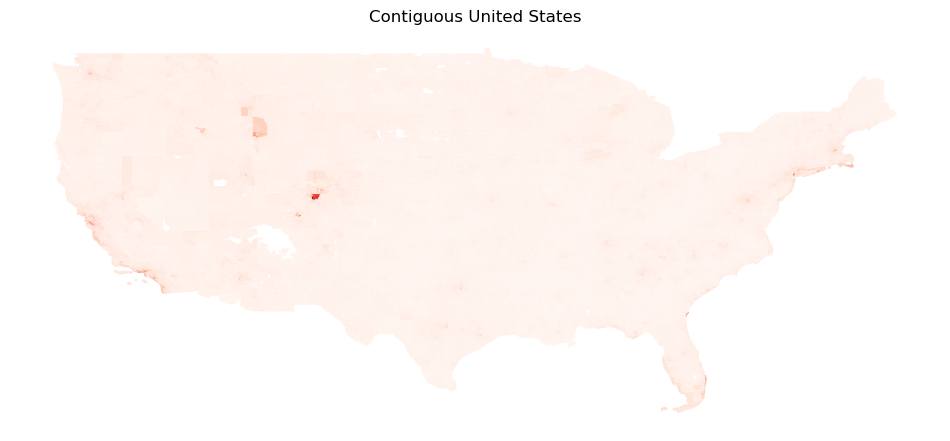

In [4]:
#
# Contiguous United States
#

# So, on a chloropleth, Denver looks like it has higher property values
# But NY has highest property value, but in a 10th the land area, so it appears smaller

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Except Alaska, Hawaii, Peurto Rico
# Except Block Groups that are covered by water

blockgrouphomevalues\
    [~blockgrouphomevalues.STATEFP.isin(['02', '15', '72', ])]\
    [blockgrouphomevalues.BLKGRPCE != 0]\
    .plot(   
    column='ZHVI Single Family Homes',  
    cmap="Reds",      
    linewidth=0.8,
    ax=ax,
    # legend=True,
)

ax.set_title("Contiguous United States")
ax.set_axis_off()
plt.show()

C:\Users\micha\anaconda3\envs\geotools\lib\site-packages\geopandas\geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
C:\Users\micha\anaconda3\envs\geotools\lib\site-packages\geopandas\geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
C:\Users\micha\anaconda3\envs\geotools\lib\site-packages\geopandas\geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


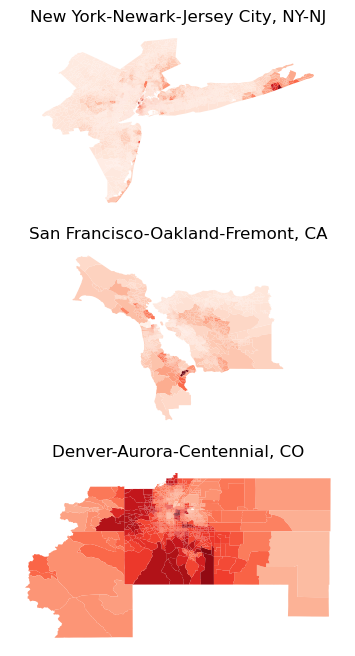

In [5]:
#
# Major Metropolitan Statistical Areas
#

# Cities aka Combined Metropolitan Statistical Areas (CSA) are defined as groups of counties with 2 digit state FIPS concat 3 digit county FIPS
# The CSA dataframe matches each city to the state & county fips keys

blockgrouphomevalues['StateCounty'] = blockgrouphomevalues.STATEFP+blockgrouphomevalues.COUNTYFP

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
# Except Block Groups that are covered by water, block group code is '0'

cities = ['New York-Newark-Jersey City, NY-NJ','San Francisco-Oakland-Fremont, CA','Denver-Aurora-Centennial, CO']
plots = 0
for city in cities:

    blockgrouphomevalues\
        [blockgrouphomevalues.StateCounty.isin(csa[csa['CBSA Title'] == city].StateCounty)]\
        [blockgrouphomevalues.BLKGRPCE != '0']\
        .plot(   
        column='ZHVI Single Family Homes',  
        cmap="Reds",      
        linewidth=0.8,
        ax=ax[plots],
        # legend=True,
    )
    
    ax[plots].set_title(city)
    ax[plots].set_axis_off()
    plots += 1
    
plt.show()

In [6]:
blockgrouphomevalues['StateCounty'] = blockgrouphomevalues.STATEFP+blockgrouphomevalues.COUNTYFP
csa['StateCounty'] = csa['FIPS State Code'] + csa['FIPS County Code']

In [7]:
csa[csa['County/County Equivalent'] == 'New York County'].StateCounty

1236    36061
Name: StateCounty, dtype: object

C:\Users\micha\anaconda3\envs\geotools\lib\site-packages\geopandas\geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<Axes: >

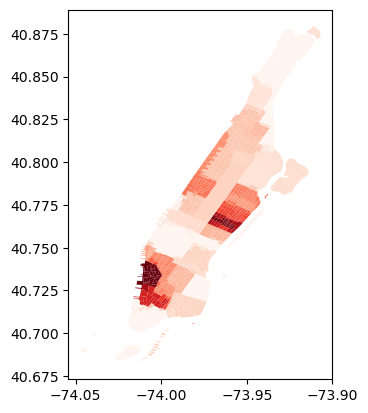

In [8]:
blockgrouphomevalues\
    [blockgrouphomevalues.BLKGRPCE != '0']\
    [blockgrouphomevalues.StateCounty == '36061']\
    .plot(   
    column='ZHVI Single Family Homes',  
    cmap="Reds",      
    linewidth=0.8,
)

In [9]:
blockgrouphomevalues[blockgrouphomevalues.StateCounty == '36061']['ZHVI Single Family Homes'].mean() # New York County

np.float64(1480213.977269591)

In [10]:
blockgrouphomevalues[blockgrouphomevalues.StateCounty == '36061']['ALAND'].mean() # New York County

np.float64(45420.95897832817)

C:\Users\micha\anaconda3\envs\geotools\lib\site-packages\geopandas\geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<Axes: >

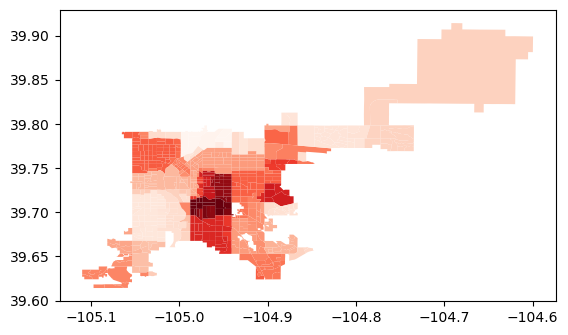

In [11]:
blockgrouphomevalues\
    [blockgrouphomevalues.BLKGRPCE != '0']\
    [blockgrouphomevalues.StateCounty == '08031']\
    .plot(   
    column='ZHVI Single Family Homes',  
    cmap="Reds",      
    linewidth=0.8,
)

In [12]:
blockgrouphomevalues[blockgrouphomevalues.StateCounty == '08031']['ZHVI Single Family Homes'].mean() # Denver County

np.float64(639735.0316363166)

In [13]:
blockgrouphomevalues[blockgrouphomevalues.StateCounty == '08031']['ALAND'].mean() # Denver County

np.float64(694325.9982486865)